# Setup

In [2]:
# Setup - Run only once per Kernel App
%conda install openjdk -y

# install PySpark
%pip install pyspark==3.3.0

# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.10.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.10.0



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - openjdk


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2023.08.22 |       h06a4308_0         123 KB
    certifi-2023.7.22          |  py310h06a4308_0         153 KB
    openjdk-11.0.13            |       h87a67e3_0       341.0 MB
    ------------------------------------------------------------
                                           Total:       341.3 MB

The following NEW packages will be INSTALLED:

  openjdk            pkgs/main/linux-64::openjdk-11.0.13-h87a67e3_0 



In [3]:
# Import pyspark and build Spark session
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder.appName("PySparkApp")
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.2.2")
    .config(
        "fs.s3a.aws.credentials.provider",
        "com.amazonaws.auth.ContainerCredentialsProvider",
    )
    .getOrCreate()
)

print(spark.version)

:: loading settings :: url = jar:file:/opt/conda/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-fde6f6f4-d468-4615-80c7-dd7f3e709851;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.2.2 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.563 in central
:: resolution report :: resolve 439ms :: artifacts dl 54ms
	:: modules in use:
	com.amazonaws#aws-java-sdk-bundle;1.11.563 from central in [default]
	org.apache.hadoop#hadoop-aws;3.2.2 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	---------------------------------------------

23/11/07 21:30:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


3.3.0


In [4]:
import sagemaker

session = sagemaker.Session()
bucket = session.default_bucket()
print(bucket)

# Create or retrieve a Spark session
spark = SparkSession.builder.appName("ReadS3Parquet").getOrCreate()


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker-us-east-1-224518912016
23/11/07 21:30:45 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


## Data

In [5]:
# S3 directory path
s3_directory = f"s3a://{bucket}/project/cleaned/comments/"

# Read all the Parquet files in the directory into a DataFrame
df_comments_conservative_finance = spark.read.parquet(s3_directory)

23/11/07 21:30:46 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


In [6]:
# S3 directory path
s3_directory = f"s3a://{bucket}/project/cleaned/submissions/"

# Read all the Parquet files in the directory into a DataFrame
df_submissions_conservative_finance = spark.read.parquet(s3_directory)

23/11/07 21:30:52 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


## Import Data from other Subreddits

In [7]:
# Tegveer subreddits
tegveer_bucket = 'sagemaker-us-east-1-433974840707'
s3_directory_tegveer = f"s3a://{tegveer_bucket}/project/cleaned/submissions/"
s3_directory_tegveer_comments = f"s3a://{tegveer_bucket}/project/cleaned/comments/"

# Read all the Parquet files in the directory into a DataFrame
df_submissions_centrist_liberterian = spark.read.parquet(s3_directory_tegveer)
df_comments_centrist_liberterian = spark.read.parquet(s3_directory_tegveer_comments)

# Eric subreddits
eric_bucket = 'sagemaker-us-east-1-395393721134'
s3_directory_eric = f"s3a://{eric_bucket}/project/cleaned/submissions/"
s3_directory_eric_comments = f"s3a://{eric_bucket}/project/cleaned/comments/"

# Read all the Parquet files in the directory into a DataFrame
df_submissions_socialism_economics_liberal = spark.read.parquet(s3_directory_eric)
df_submissions_socialism_economics_liberal_comments = spark.read.parquet(s3_directory_eric_comments)

# Anthony subreddits
anthony_bucket = 'sagemaker-us-east-1-711387073580'
s3_directory_anthony_submissions = f"s3a://{anthony_bucket}/project/cleaned/submissions/"
s3_directory_anthony_comments = f"s3a://{anthony_bucket}/project/cleaned/comments/"

# Read all the Parquet files in the directory into a DataFrame
df_submissions_askpolitics_changemyview = spark.read.parquet(s3_directory_anthony_submissions)
df_comments_askpolitics_changemyview = spark.read.parquet(s3_directory_anthony_comments)


In [8]:
# extract other subreddits

import pyspark.sql.functions as f
from pyspark.sql.functions import col
from pyspark.sql.types import StringType

df_submissions_finance = df_submissions_conservative_finance.filter(col("subreddit")=="finance")
df_submissions_economics = df_submissions_socialism_economics_liberal.filter(col("subreddit")=="Economics")
df_submissions_conservative = df_submissions_conservative_finance.filter(col("subreddit")=="Conservative")

In [9]:
df_submissions_economics.printSchema()

root
 |-- author: string (nullable = true)
 |-- title: string (nullable = true)
 |-- selftext: string (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- score: long (nullable = true)
 |-- num_comments: long (nullable = true)
 |-- permalink: string (nullable = true)
 |-- created_utc: timestamp (nullable = true)
 |-- url: string (nullable = true)
 |-- domain: string (nullable = true)
 |-- is_video: boolean (nullable = true)
 |-- is_self: boolean (nullable = true)
 |-- is_reddit_media_domain: boolean (nullable = true)
 |-- spoiler: boolean (nullable = true)
 |-- over_18: boolean (nullable = true)
 |-- stickied: boolean (nullable = true)
 |-- thumbnail: string (nullable = true)
 |-- media: struct (nullable = true)
 |    |-- event_id: string (nullable = true)
 |    |-- oembed: struct (nullable = true)
 |    |    |-- author_name: string (nullable = true)
 |    |    |-- author_url: string (nullable = true)
 |    |    |-- cache_age: long (nullable = true)
 |    |    |-- descriptio

In [10]:
from pyspark.sql.functions import year, month, count

# group by year and month extracted from created_utc and count the number of rows
df_grouped_by_year_month = df_submissions_economics \
    .groupBy(year("created_utc").alias("year"), month("created_utc").alias("month")) \
    .count()

# order by year and month
df_grouped_by_year_month = df_grouped_by_year_month.orderBy("year", "month")

# show the result
df_grouped_by_year_month.show()


+----+-----+-----+
|year|month|count|
+----+-----+-----+
|2021|    1| 1358|
|2021|    2| 1348|
|2021|    3| 1431|
|2021|    4| 1455|
|2021|    5| 1132|
|2021|    6| 1076|
|2021|    7|  939|
|2021|    8|  828|
|2021|    9| 1061|
|2021|   10|  852|
|2021|   11|  765|
|2021|   12| 1048|
|2022|    1| 1177|
|2022|    2|  936|
|2022|    3| 1234|
|2022|    4|  984|
|2022|    5| 1110|
|2022|    6| 1223|
|2022|    7| 1256|
|2022|    8| 4480|
+----+-----+-----+
only showing top 20 rows



In [11]:
# order by count of submissions in descending order
df_grouped_by_year_month = df_grouped_by_year_month.orderBy("count", ascending=False)

# show the result
df_grouped_by_year_month.show()

+----+-----+-----+
|year|month|count|
+----+-----+-----+
|2022|    9| 6675|
|2022|    8| 4480|
|2023|    3| 1644|
|2022|   10| 1593|
|2021|    4| 1455|
|2021|    3| 1431|
|2022|   11| 1374|
|2021|    1| 1358|
|2021|    2| 1348|
|2023|    1| 1301|
|2022|    7| 1256|
|2022|    3| 1234|
|2022|   12| 1224|
|2022|    6| 1223|
|2022|    1| 1177|
|2021|    5| 1132|
|2022|    5| 1110|
|2023|    2| 1100|
|2021|    6| 1076|
|2021|    9| 1061|
+----+-----+-----+
only showing top 20 rows



In [68]:
from pyspark.sql.functions import year, month, avg

# Group by year and month extracted from created_utc and calculate the average score
df_avg_score_by_year_month = df_submissions_economics \
    .groupBy(year("created_utc").alias("year"), month("created_utc").alias("month")) \
    .agg(avg("score").alias("average_score"))

# Order by year and month
df_avg_score_by_year_month = df_avg_score_by_year_month.orderBy("year", "month")

# Show the result
df_avg_score_by_year_month.show()


+----+-----+------------------+
|year|month|     average_score|
+----+-----+------------------+
|2021|    1|246.18114874815905|
|2021|    2|138.58679525222553|
|2021|    3| 171.7393431167016|
|2021|    4| 153.3786941580756|
|2021|    5|155.07508833922262|
|2021|    6|128.57620817843866|
|2021|    7|110.50053248136315|
|2021|    8|148.81521739130434|
|2021|    9| 144.0923656927427|
|2021|   10|176.42723004694835|
|2021|   11|176.98431372549018|
|2021|   12|132.48664122137404|
|2022|    1|145.80798640611724|
|2022|    2|313.80555555555554|
|2022|    3| 296.3095623987034|
|2022|    4| 271.3973577235772|
|2022|    5| 317.7477477477477|
|2022|    6|282.42191332788224|
|2022|    7|282.11544585987264|
|2022|    8| 66.63995535714285|
+----+-----+------------------+
only showing top 20 rows



In [12]:
from pyspark.sql.functions import year, month, min, max

# get year and month 
df_with_year_month = df_submissions_economics \
    .withColumn("year", year("created_utc")) \
    .withColumn("month", month("created_utc"))

# get range
min_date = df_with_year_month.select(min("year"), min("month")).first()
max_date = df_with_year_month.select(max("year"), max("month")).first()

print(f"Earliest date: {min_date['min(year)']}-{min_date['min(month)']:02d}")
print(f"Latest date: {max_date['max(year)']}-{max_date['max(month)']:02d}")


Earliest date: 2021-01
Latest date: 2023-12


## Import External Data

In [15]:
import os
import pandas as pd
os.getcwd()

'/root/project/fall-2023-reddit-project-team-01/code/eda'

In [21]:
unemployment = pd.read_csv("../../data/csv/unemployment.csv", index_col = 0)
fed_funds = pd.read_csv("../../data/csv/fed_funds.csv", index_col = 0)
gdp = pd.read_csv("../../data/csv/gdp.csv", index_col = 0)

In [43]:
real_gdp = pd.read_csv("../../data/csv/real_gdp.csv", index_col = 0)

In [44]:
real_gdp.head()

,value,date
0,19055.655,2021-01
1,19358.176,2021-04
2,19465.195,2021-07
3,19805.962,2021-10
4,19727.918,2022-01


In [30]:
gdp['date'] = pd.to_datetime(gdp['date'], format = "%Y/%m")
gdp.dtypes

value           float64
date     datetime64[ns]
dtype: object

In [31]:
df_grouped_by_year_month.printSchema()

root
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- count: long (nullable = false)



In [27]:
type(df_grouped_by_year_month)

pyspark.sql.dataframe.DataFrame

In [33]:
# convert Spark DataFrame to Pandas DataFrame
df_grouped_by_year_month_pd = df_grouped_by_year_month.toPandas()

# combine 'year' and 'month' into a 'date' column and convert to datetime
df_grouped_by_year_month_pd['date'] = pd.to_datetime(df_grouped_by_year_month_pd.assign(day=1)[['year', 'month', 'day']])


In [69]:
df_avg_score_by_year_month
# convert Spark DataFrame to Pandas DataFrame
df_avg_score_by_year_month_pd = df_avg_score_by_year_month.toPandas()

# combine 'year' and 'month' into a 'date' column and convert to datetime
df_avg_score_by_year_month_pd['date'] = pd.to_datetime(df_avg_score_by_year_month_pd.assign(day=1)[['year', 'month', 'day']])

In [70]:
df_avg_score_by_year_month_pd.head()

,year,month,average_score,date
0,2021,1,246.181149,2021-01-01
1,2021,2,138.586795,2021-02-01
2,2021,3,171.739343,2021-03-01
3,2021,4,153.378694,2021-04-01
4,2021,5,155.075088,2021-05-01


In [77]:
combined_gdp_score = pd.merge(df_avg_score_by_year_month_pd, real_gdp, on='date', how='left')

In [74]:
combined_gdp_score.head()

,year,month,average_score,date,value
0,2021,1,246.181149,2021-01-01,22187.2805
1,2021,2,138.586795,2021-02-01,NaN
2,2021,3,171.739343,2021-03-01,NaN
3,2021,4,153.378694,2021-04-01,22906.8410
4,2021,5,155.075088,2021-05-01,NaN


In [78]:
combined_gdp_score['value_shifted'] = combined_gdp_score['value'].shift(3)

In [80]:
combined_gdp_score.head(10)

,year,month,average_score,date,value,value_shifted
0,2021,1,246.181149,2021-01-01,19055.655,NaN
1,2021,2,138.586795,2021-02-01,NaN,NaN
2,2021,3,171.739343,2021-03-01,NaN,NaN
3,2021,4,153.378694,2021-04-01,19358.176,19055.655
4,2021,5,155.075088,2021-05-01,NaN,NaN
5,2021,6,128.576208,2021-06-01,NaN,NaN
6,2021,7,110.500532,2021-07-01,19465.195,19358.176
7,2021,8,148.815217,2021-08-01,NaN,NaN
8,2021,9,144.092366,2021-09-01,NaN,NaN
9,2021,10,176.427230,2021-10-01,19805.962,19465.195


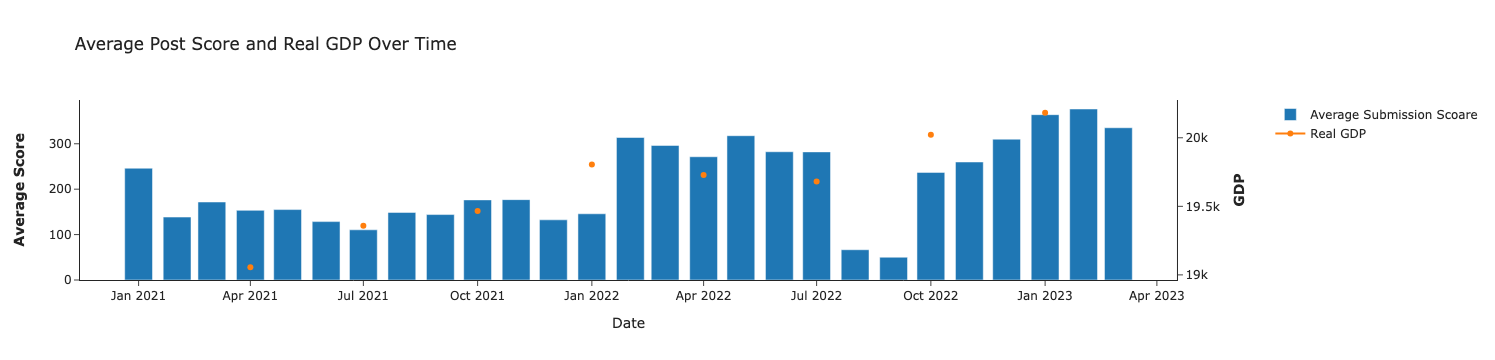

In [79]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# create a subplot with 2 y-axes
fig = make_subplots(specs=[[{"secondary_y": True}]])

# add the bar plot for the number of Reddit submissions
fig.add_trace(
    go.Bar(x=combined_gdp_score['date'], y=combined_gdp_score['average_score'], name='Average Submission Scoare'),
    secondary_y=False,
)

# add the line plot for the GDP with the values shifted as required
fig.add_trace(
    go.Scatter(x=combined_gdp_score['date'], y=combined_gdp_score['value_shifted'], name='Real GDP', mode='lines+markers'),
    secondary_y=True,
)

# set x-axis title
fig.update_xaxes(title_text="Date")

# set y-axes titles
fig.update_yaxes(title_text="<b>Average Score</b>", secondary_y=False)
fig.update_yaxes(title_text="<b>GDP</b>", secondary_y=True)

# set plot title and apply the 'simple_white' template
fig.update_layout(
    title_text="Average Post Score and Real GDP Over Time",
    template="simple_white"
)

# show plot
fig.show()


In [35]:
# Merge on the 'date' column
combined_gdp = pd.merge(df_grouped_by_year_month_pd, gdp, on='date', how='left')

In [36]:
combined_gdp.head()

,year,month,count,date,value
0,2022,9,6675,2022-09-01,NaN
1,2022,8,4480,2022-08-01,NaN
2,2023,3,1644,2023-03-01,NaN
3,2022,10,1593,2022-10-01,26205.95275
4,2021,4,1455,2021-04-01,22906.84100


In [45]:
real_gdp['date'] = pd.to_datetime(real_gdp['date'], format = "%Y/%m")
real_gdp.dtypes

value           float64
date     datetime64[ns]
dtype: object

In [50]:
real_gdp.head(10)

,value,date
0,19055.655,2021-01-01
1,19358.176,2021-04-01
2,19465.195,2021-07-01
3,19805.962,2021-10-01
4,19727.918,2022-01-01
5,19681.682,2022-04-01
6,20021.721,2022-07-01
7,20182.491,2022-10-01
8,20235.878,2023-01-01
9,20386.467,2023-04-01


In [46]:
combined_real_gdp = pd.merge(df_grouped_by_year_month_pd, real_gdp, on='date', how='left')

In [53]:
combined_real_gdp = combined_real_gdp.sort_values(by='date')

In [59]:
combined_real_gdp['value_shifted'] = combined_real_gdp['value'].shift(3)

In [60]:
combined_real_gdp.head(20)

,year,month,count,date,value,value_shifted
7,2021,1,1358,2021-01-01,19055.655,NaN
8,2021,2,1348,2021-02-01,NaN,NaN
5,2021,3,1431,2021-03-01,NaN,NaN
4,2021,4,1455,2021-04-01,19358.176,19055.655
15,2021,5,1132,2021-05-01,NaN,NaN
18,2021,6,1076,2021-06-01,NaN,NaN
22,2021,7,939,2021-07-01,19465.195,19358.176
25,2021,8,828,2021-08-01,NaN,NaN
19,2021,9,1061,2021-09-01,NaN,NaN
24,2021,10,852,2021-10-01,19805.962,19465.195


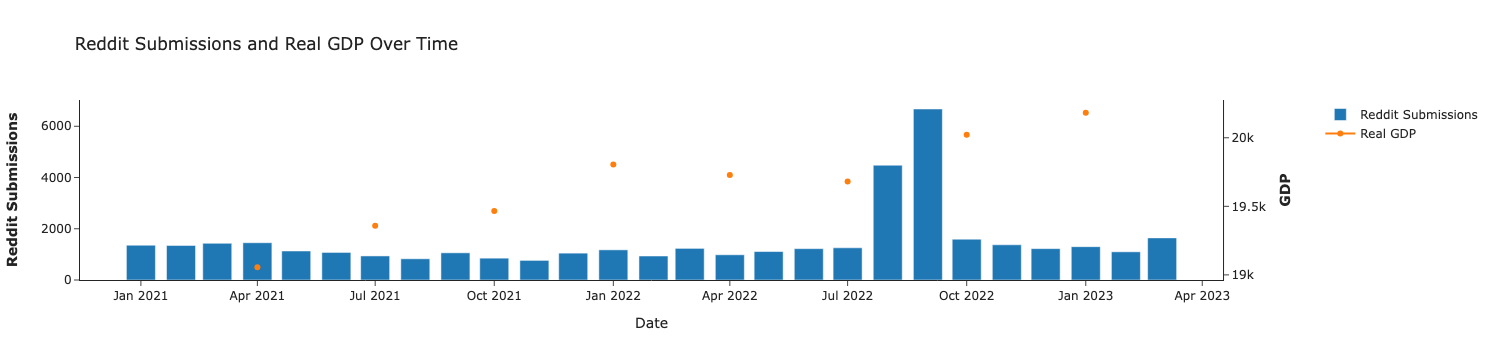

In [66]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# create a subplot with 2 y-axes
fig = make_subplots(specs=[[{"secondary_y": True}]])

# add the bar plot for the number of Reddit submissions
fig.add_trace(
    go.Bar(x=combined_real_gdp['date'], y=combined_real_gdp['count'], name='Reddit Submissions'),
    secondary_y=False,
)

# add the line plot for the GDP with the values shifted as required
fig.add_trace(
    go.Scatter(x=combined_real_gdp['date'], y=combined_real_gdp['value_shifted'], name='Real GDP', mode='lines+markers'),
    secondary_y=True,
)

# set x-axis title
fig.update_xaxes(title_text="Date")

# set y-axes titles
fig.update_yaxes(title_text="<b>Reddit Submissions</b>", secondary_y=False)
fig.update_yaxes(title_text="<b>GDP</b>", secondary_y=True)

# set plot title and apply the 'simple_white' template
fig.update_layout(
    title_text="Reddit Submissions and Real GDP Over Time",
    template="simple_white"
)

# show plot
fig.show()
